In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import seaborn as sns
sns.set(style='white', palette='bright')
plt.rcParams['figure.figsize'] = (20,10)

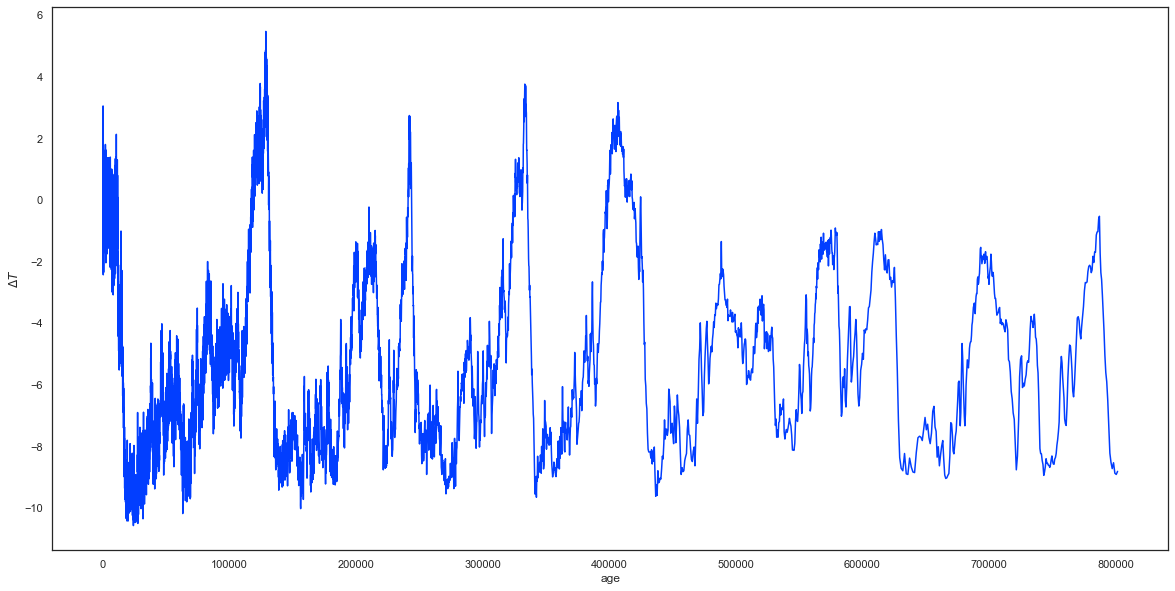

In [3]:
# Setting up the data to show how the Earth's temperature flucuates overtime by looking at Milankovich cycles. 

ice_data = np.loadtxt('https://prappleizer.github.io/Tutorials/MCMC/ice_core_data.txt')
ice_data = np.transpose(ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel(r'$\Delta T$')
plt.show()

In [4]:
# In order to use a Markov-Chain Monte Carlo we need to define what our v0 will be. Since the above graph looks like a sin wave we will go with this model to try to fit it.
# We need to have priors, which is us inputting what we think we know about the model into it.

def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

In [5]:
# This function returns a number corresponding to how good a fit the model is 
# to your data for a given set of parameters, weighted by the error in your data points 
# (i.e. it is more important the fit be close to data points with small error bars than points with large error bars)
# If the process deems this model to be better than the previous (by using a ratio) it continues on with this model

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

In [6]:
# We now need to set the bounds for our data. If we look at the above graph it is easy to set them as we cannot go above or below the peaks and troughs.
# We are setting the bounds of the x-axis with known Milankovich cycles of every 10,000 to 20,000 years. Theta needs to be constrained as well to make sure it is within bounds.

def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

In [7]:
# Running the above fucntions through a test to check to make sure all our priors are good. To infinity and beyond.

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [9]:
# First we need to come up an error for the model. We are assuming 5% and the number of walkers plus itterations which are 128 and 500 respectively.
# p0 is the methodology from stepping from one grid to the next. Initial is our initial set of guesses.

Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 128
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
# Running the model. Check documentation.

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [11]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [12]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

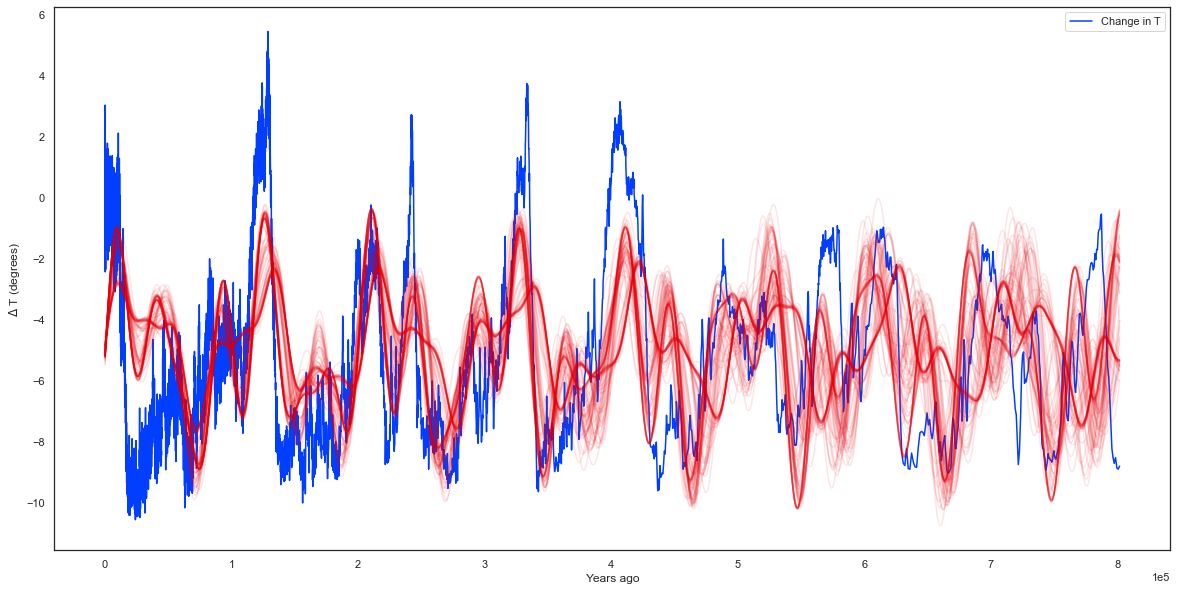

In [13]:
plotter(sampler)

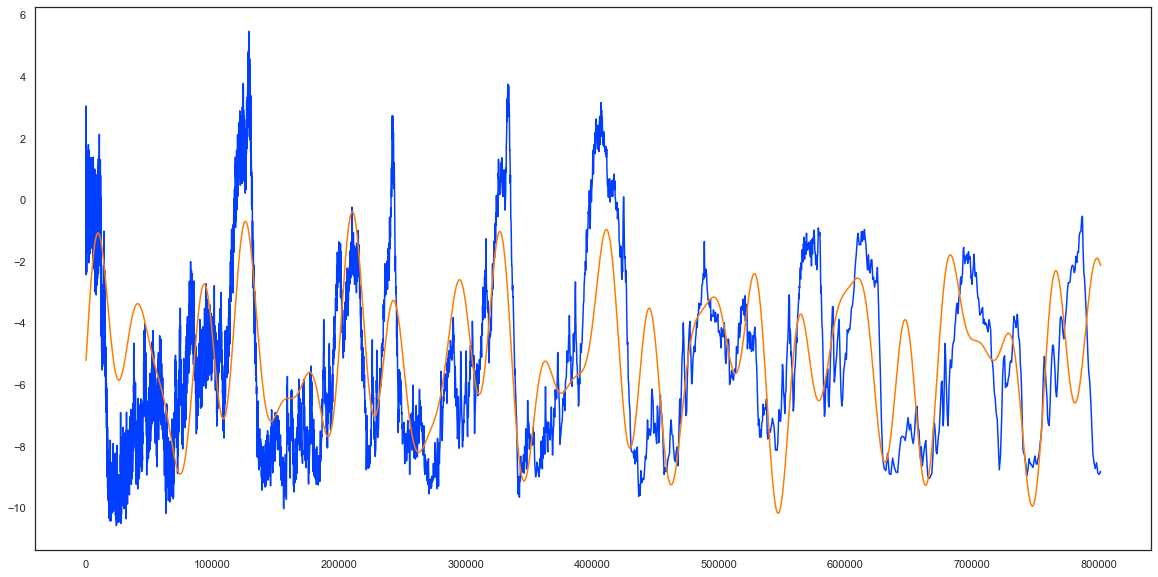

Theta max:  [ 1.20101534e+00  2.03427167e+00  1.82283446e+00  2.91376393e+04
  3.97637338e+04  9.60183784e+04 -5.24080778e+00]


In [15]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',theta_max)

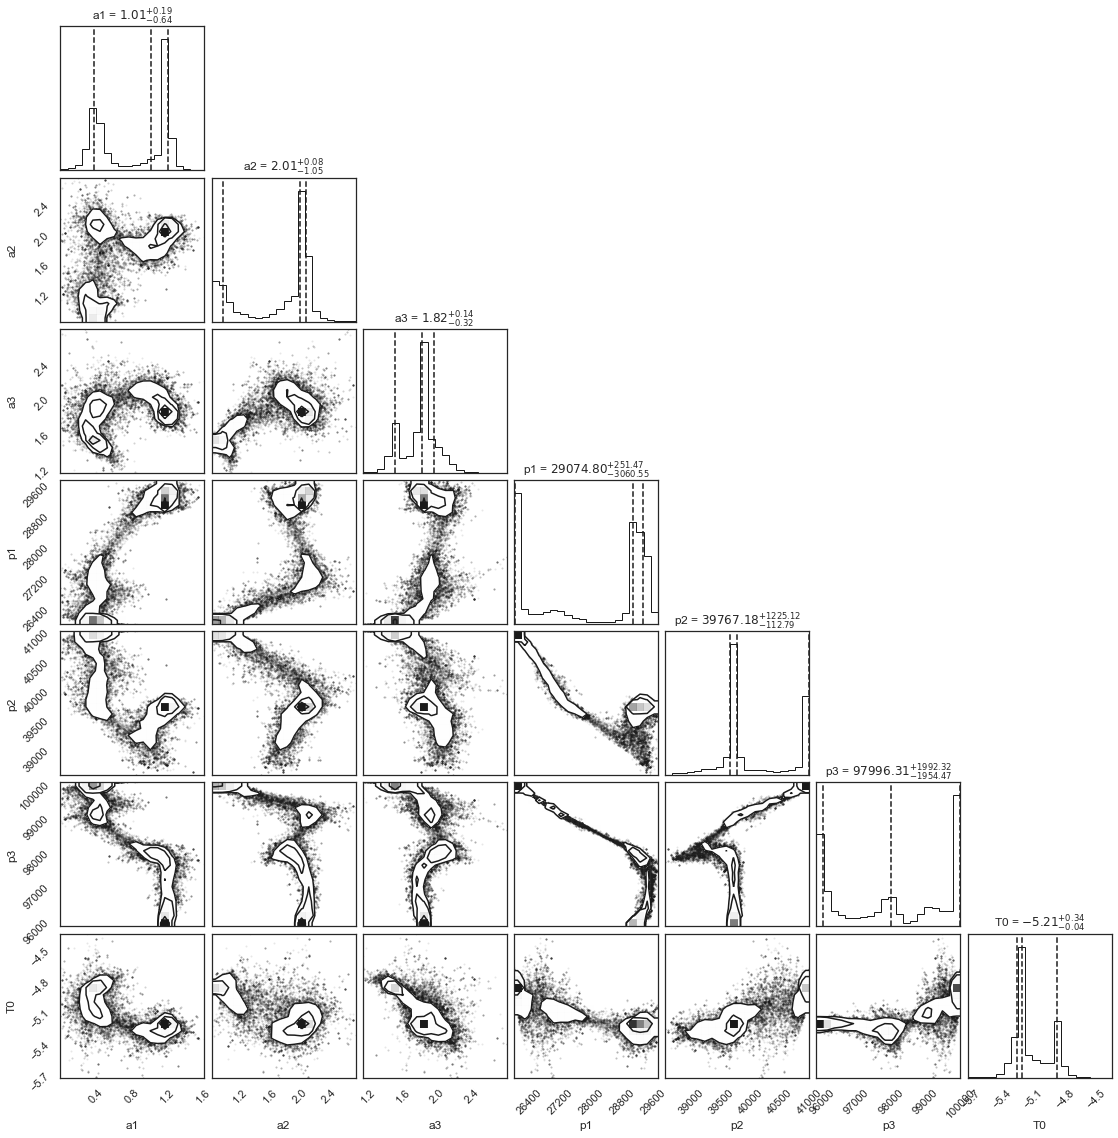

In [16]:
# So we find that our amplitudes are 1.20, 2.03, and 1.82 (seems about right, they should be less than around 5), 
# we get periods of 29,138 years, 39,764 years, and 96,018 years (pretty close to our predictions of 26,000, 41,000, and 100,000 years), and a  
# T0  of -5.24 degrees, which we almost could've read straight off the graph in the first place.

labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [17]:
# Not a very good picture above with clumping two peaks at different amplitudes. This means the model was not able to converage on a single answer. Running more itterations will hopefully fix.

Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 240
niter = 1024
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


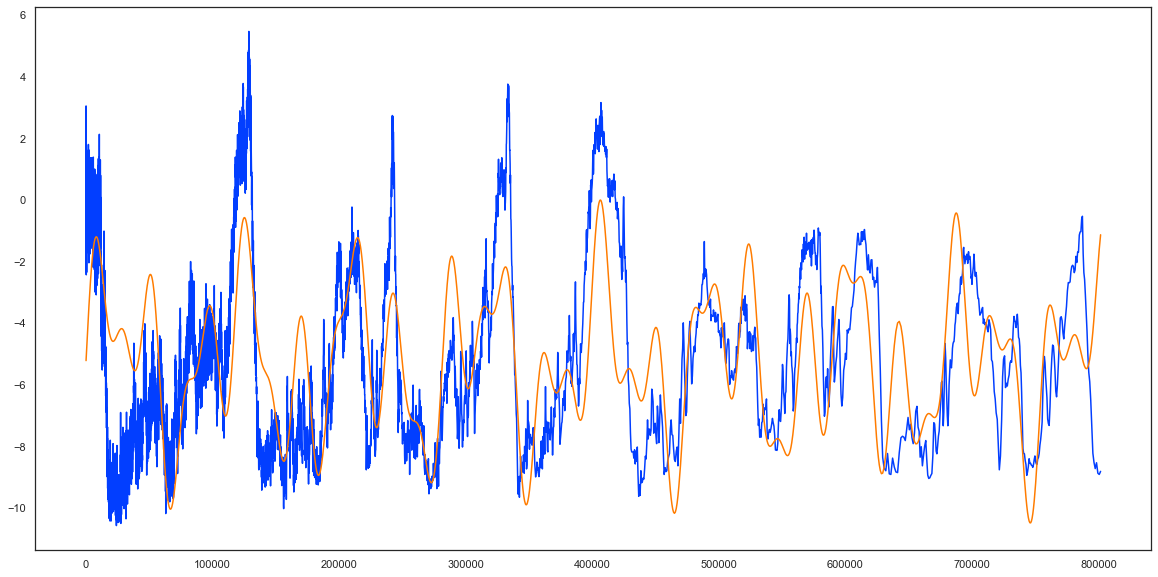

Theta max:  [ 1.32465570e+00  2.08028425e+00  1.89544160e+00  2.35218298e+04
  3.97334981e+04  9.61339424e+04 -5.25630923e+00]


In [18]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',new_theta_max)

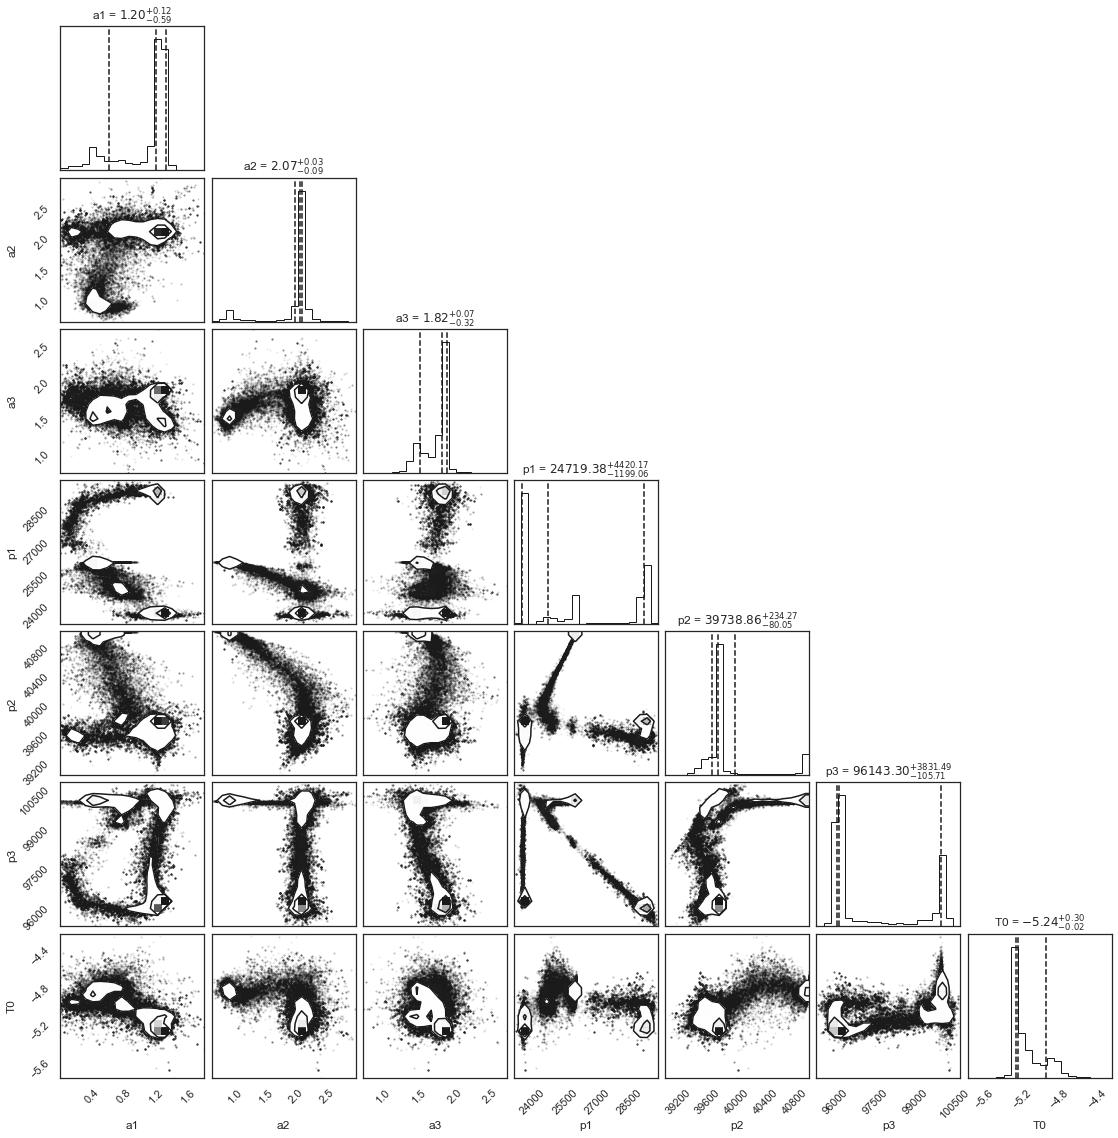

In [19]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [20]:
# Secondary modes we saw in the first seem to be supressed which is good. Now lets plot a one sigma spread at the posteriors on the x-values. We just take a random sample adn find the spread.

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

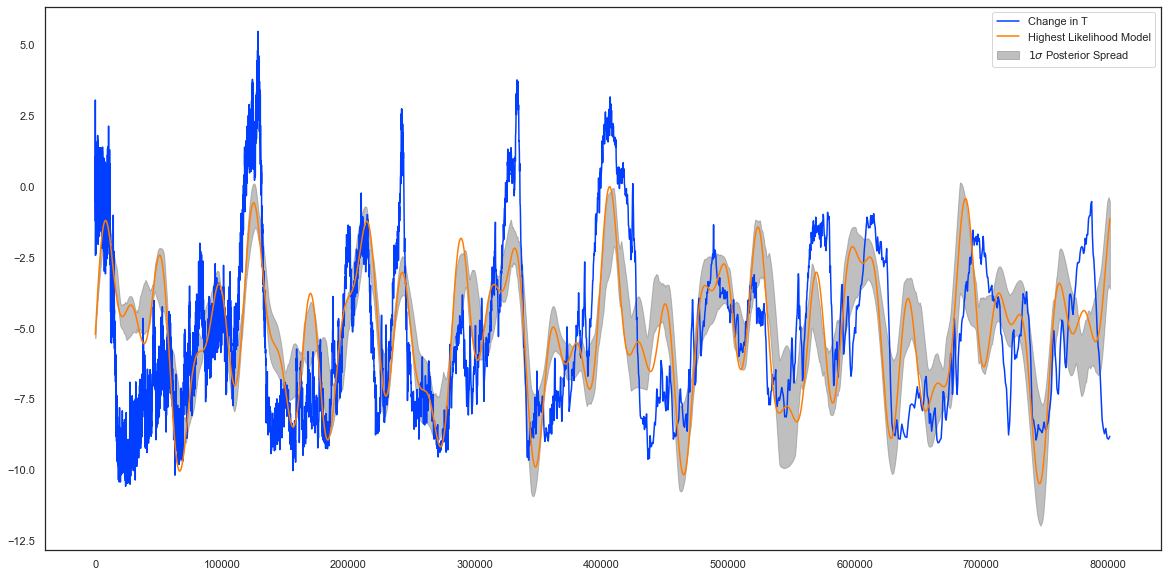

In [21]:
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()